In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import gamma
import os
# there has been some incompatibilty between theano and numpy, if you encounter
# an error with the latest packages from anaconda, then the included
# package-list-txt should allow you to create a conda environment with compatible
# packages.

In [3]:
medical = pd.read_csv('insurance2-Copy1.csv')

In [4]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [5]:
insurance = medical.charges[medical.insuranceclaim == 1]
no_insurance = medical.charges[medical.insuranceclaim == 0]
n_ins = len(insurance)
n_no_ins = len(no_insurance)

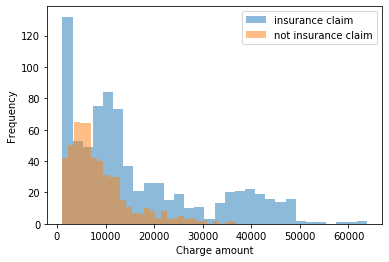

In [6]:
_ = plt.hist(insurance, bins=30, alpha=0.5, label='insurance claim')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='not insurance claim')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

In [7]:
alpha_est = np.mean(no_insurance)**2 / np.var(no_insurance)
beta_est = np.var(no_insurance) / np.mean(no_insurance)
alpha_est, beta_est

(1.8759059725250895, 4702.486170152818)

In [8]:
seed(47)
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)

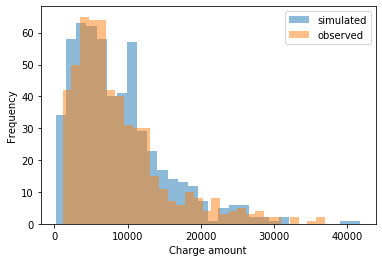

In [9]:
_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

In [10]:
# PyMC3 Gamma seems to use rate = 1/beta
rate_est = 1/beta_est
# Initial parameter estimates we'll use below
alpha_est, rate_est

(1.8759059725250895, 0.00021265346963636103)

__Q:__ You are now going to create your own PyMC3 model!
1. Use an [exponential](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Exponential) prior for alpha. Call this stochastic variable `alpha_`.
2. Similarly, use an exponential prior for the rate ([$1/\beta$](https://wiki.analytica.com/index.php?title=Gamma_distribution)) parameter in PyMC3's [Gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma). Call this stochastic variable `rate_` (but it will be supplied as `pm.Gamma`'s `beta` parameter). Hint: to set up a prior with an exponential distribution for $x$ where you have an initial estimate for $x$ of $x_0$, use a scale parameter of $1/x_0$.
5. Create your Gamma distribution with your `alpha_` and `rate_` stochastic variables and the observed data.
6. Perform 10000 draws.

Hint: you may find it helpful to work backwards. Start with your `pm.Gamma`, and note the required stochastic variables `alpha` and `beta`. Then, before that, you need to create those stochastic variables using `pm.Exponential` and the correct parameters.

__A:__

In [14]:
with pm.Model() as model:
    alpha_ = pm.Exponential('alpha', alpha_est)
    rate_ = pm.Exponential('rate', rate_est)
    obs = pm.Gamma('obs', alpha_, rate_, observed=no_insurance)
    trace = pm.sample(10000, step=pm.Metropolis())
    burned_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [rate]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:04<00:00, 8892.36draws/s] 
The number of effective samples is smaller than 10% for some parameters.


__Q:__ Explore your posteriors for $\alpha$ and $\beta$ (from the trace).
* Calculate the 95% credible interval for $\alpha$ and $\beta$.
* Plot your posterior values of $\alpha$ and $\beta$ (both line plots and histograms). 
* Mark your CIs on the histograms.
* Do they look okay? What would bad plots look like?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efd5e671f28>],
      dtype=object)

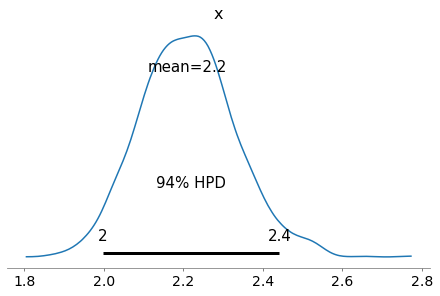

In [16]:
pm.plot_posterior(burned_trace['alpha'])

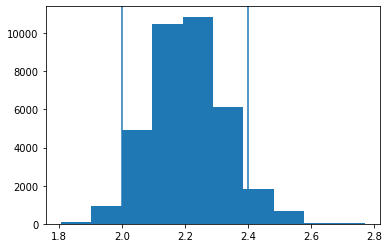

In [17]:
_ = plt.hist(burned_trace['alpha'])
_ = plt.axvline(2)
_ = plt.axvline(2.4)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efd4af7d710>],
      dtype=object)

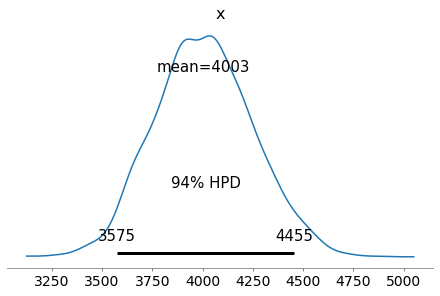

In [18]:
pm.plot_posterior(1.0/burned_trace['rate'])

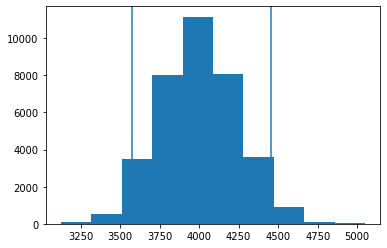

In [19]:
_ = plt.hist(1.0/burned_trace['rate'])
_ = plt.axvline(3575)
_ = plt.axvline(4455)

These graphs look good, if the graphs did not look good they would have an odd distribution and not a normal one like we see here

__Q:__ Play around with some of the built-in diagnostic plots for your model. We suggest at least checking out the traceplot for alpha and beta. How do they look?

__A:__

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efd4adcf438>],
      dtype=object)

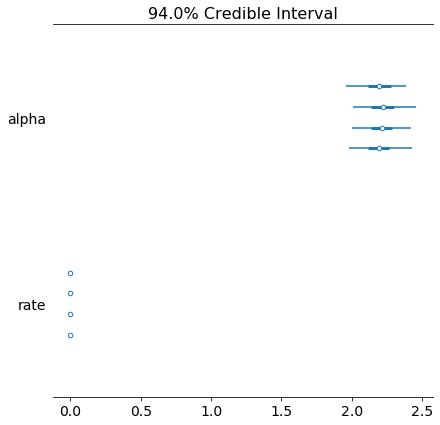

In [23]:
pm.forestplot(burned_trace)

/home/michael/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/michael/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/michael/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/michael/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efd4a390278>,
      dtype=object)

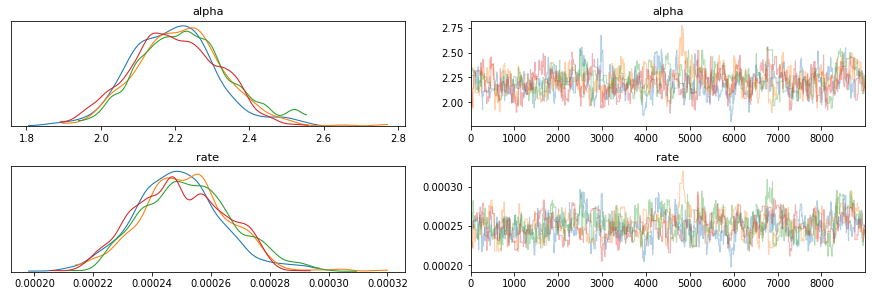

In [24]:
pm.traceplot(burned_trace)

__Q:__ Take your best shot at a new simulated sequence of medical charges using scipy.stat's gamma distribution. Don't forget the difference between functions that take $\beta$ and functions that use $1/\beta$ for the scale parameter. Simulate a data set the same size as the number of observations in the data and overlay the two histograms (simulated and observed).

__A:__

In [27]:
random_set = gamma.rvs(2.2, scale=4003, size=n_no_ins)

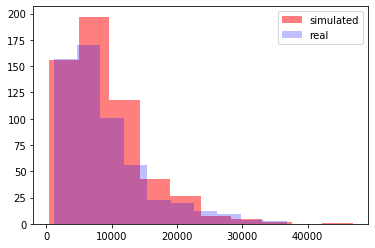

In [28]:
plt.hist(random_set, alpha=.5, color='r', label='simulated')
plt.hist(no_insurance, alpha=.25, color='b', label='real')
plt.legend(loc='upper right')
plt.show()